In [275]:
import os
from datetime import datetime
import pandas as pd
from unidecode import unidecode

# Arial font
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

raw_data_path = '/Users/rajivmovva/data/instagram/nba/'
stats_path = '/Users/rajivmovva/data/instagram/nba_stats/'

## Data work

In [115]:
'''
The directory contains lots of .txt files of the format:
    '2023-11-13_04-43-48_UTC.txt'

Get every file matching this format and read the contents
into a dataframe with two columns:
    1. 'date' - Date + time as datetime object
    2. 'text' - The content of the text file
'''

date_threshold = datetime(2023, 10, 23)

boilerplate_phrases = [
    # 'Watch all games FREE on the NBA App with your NBA ID!',
    '<Watch LIVE on the NBA App',
    '<watch',
    # 'NBA In-Season Tournament',
    'Watch '
]
boilerplate_phrases = {phrase: 0 for phrase in boilerplate_phrases}
def parse_caption(caption):
    '''
    Replace all whitespace characters with spaces.

    Remove random NBA fillertext in the caption, like:

    'Watch all games FREE on the NBA App with your NBA ID!'
    '<Watch LIVE on the NBA App • link in bio>'

    Find phrases like this and remove this text + all text after it.
    '''

    # Only include the caption text before the first of these phrases
    for phrase in boilerplate_phrases:
        if phrase in caption:
            caption = caption.split(phrase)[0]
            boilerplate_phrases[phrase] += 1
            break

    caption = ' '.join(caption.split())

    return caption


df_data = {'date': [], 'caption': [], 'likes': [], 'comments': []}
for file in os.listdir(raw_data_path):
    if not file.endswith('.txt'):
        continue

    datetime_str = file.split('_')[0] + '_' + file.split('_')[1]
    dt = datetime.strptime(datetime_str, '%Y-%m-%d_%H-%M-%S')
    if dt < date_threshold:
        continue

    with open(raw_data_path + file, 'r') as f:
        text = f.read()
        caption, likes, comments = text.split('/////')
    df_data['date'].append(dt)
    
    caption = caption.split('Caption: ')[1]
    likes = likes.split('Likes: ')[1]
    comments = comments.split('Comments: ')[1]
    
    df_data['caption'].append(parse_caption(caption))
    df_data['likes'].append(int(likes))
    df_data['comments'].append(int(comments))

print(boilerplate_phrases)

df = pd.DataFrame(df_data).sort_values(by='date').reset_index(drop=True)
# Controversial posts have high comment/like ratio
df['comments:likes'] = df['comments'] / df['likes']

print(df.shape)
display(df.head())

{'<Watch LIVE on the NBA App': 182, '<watch': 16, 'Watch ': 58}
(2788, 5)


,date,caption,likes,comments,comments:likes
0,2023-10-23 00:26:35,The BEST BLOCKS from the #NBAPreseason! 🚫 #Kia...,89971,194,0.002156
1,2023-10-23 02:36:25,The BEST HANDLES from the #NBAPreseason! #KiaT...,270878,537,0.001982
2,2023-10-23 04:46:52,Some legendary first career buckets! 👀 #KiaTip...,418306,1196,0.002859
3,2023-10-23 11:06:28,🚨 NBA JERSEY DAY IS HERE! 🚨 Participate alongs...,60074,471,0.007840
4,2023-10-23 14:00:52,stepping into #nbajerseyday like…,135804,179,0.001318


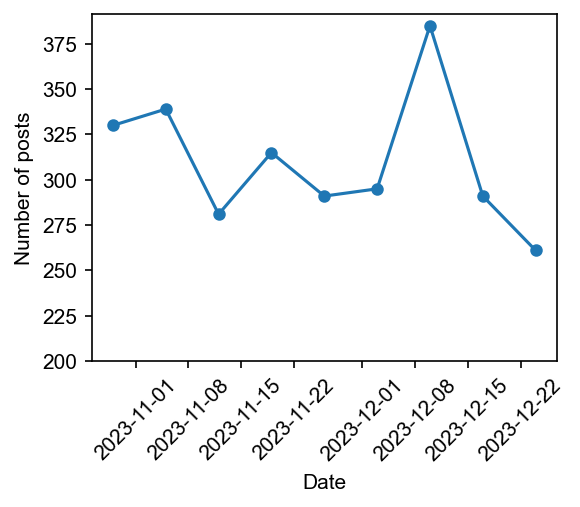

In [96]:
# Display linegraph of posts per month
new_df = df.copy()
# new_df['month'] = df['date'].apply(lambda x: x.month)
# new_df['year'] = df['date'].apply(lambda x: x.year)
# new_df['month_year'] = new_df['month'].astype(str) + '-' + new_df['year'].astype(str)
# new_df['month_year'] = pd.to_datetime(new_df['month_year'], format='%m-%Y')
# counts_by_date = new_df.groupby('month_year').count()['date']

new_df['date_only'] = df['date'].apply(lambda x: x.date())
counts_by_date = new_df.groupby('date_only').count()['date']

# Group counts_by_date over week
# convert counts_by_date to datetime index
counts_by_date = pd.DataFrame(counts_by_date)
counts_by_date.index = pd.to_datetime(counts_by_date.index)
counts_by_date = counts_by_date.resample('W').sum()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(counts_by_date, marker='o', markersize=5)#, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Number of posts')
# Rotate x-axis labels
plt.xticks(rotation=45)
# y-axis lim at 0
plt.ylim(bottom=200)
plt.show()

In [201]:
# Load the prompt and print it
with open('prompt.txt', 'r') as f:
    prompt = f.read()

def get_captions_list_str(captions):
    res = "captions = [\n"
    for caption in captions:
        if "'" in caption:
            res += ' "' + caption + '",\n'
        else:
            res += " '" + caption + "',\n"
    res += "]"
    return res

def get_full_prompt(captions):
    return prompt + get_captions_list_str(captions) + '\n\nplayer_lists = '

# Print out example list of captions
print(get_captions_list_str(df['caption'].sample(10)))

captions = [
 'Swipe through to recap Thursday’s action!',
 'Could the players guess how many poker chips were placed in the NBA Cup? 🏆 The semifinals of the In-Season Tournament begin at 5:00 pm/et TODAY on ESPN & TNT!',
 '@chet_holmgren spins for the @okcthunder slam! 💥 #NBARooks',
 '@lukadoncic with his 6th triple of the first-half on @nbatv! 💦',
 'As KEVIN DURANT entered the TOP 10 on the all-time SCORING LIST, we showcase the elite list! 10. Kevin Durant. 9. Carmelo Anthony 8. Shaquille O’Neal 7. Wilt Chamberlain 6. Dirk Nowitzki 5. Michael Jordan 4. Kobe Bryant 3. Karl Malone 2. Kareem Abdul-Jabbar 1. LeBron James',
 '🚨 NBA JERSEY DAY IS HERE! 🚨 Participate alongside fans from around the world by wearing your favorite jersey ALL DAY TODAY and share using the hashtag #NBAJerseyDay! The 2023-24 season tips Tuesday night at 7:30pm/et on TNT! #KiaTipOff23',
 '🐜 ANT with the euro and reverse layup! Timberwolves/Suns on NBA App',
 'Magic Johnson ➡️ Paolo Banchero Take a look back at th

In [202]:
from openai import OpenAI
import os
import ast

client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],
)

def get_playerlist_completion(captions, openai_model_name='gpt-4-1106-preview', seed=0):
    messages = [{"role": "system", "content": "You are a helpful assistant."}]
    full_prompt = get_full_prompt(captions)
    messages.append({"role": "user", "content": full_prompt})

    response = client.chat.completions.create(
        model=openai_model_name,
        messages=messages,
        seed=seed,
    )

    response_content = response.choices[0].message.content
    if 'plaintext' in response_content:
      response_content = response_content.strip("`plaintext\n")
    elif 'python' in response_content:
      response_content = response_content.strip("`python\n")
    elif 'player_lists = ' in response_content:
      response_content = response_content.split('player_lists = ')[1]
    else:
      try:
        return ast.literal_eval(response_content)
      except:
        print(response_content)
        return [None for _ in range(len(captions))]
    
    return ast.literal_eval(response_content)

sample_captions = df['caption'].sample(10)
print("A sample list of captions:\n", get_captions_list_str(sample_captions))
model_output = get_playerlist_completion(sample_captions)
print("Model's evaluated response:\n", model_output)

A sample list of captions:
 captions = [
 'Steph from deep in the corner.. splash! 💦',
 'A @kingjames JAM ‼️ Kings/Lakers live on ESPN',
 'Former Clippers @reggie_jackson & deandre connected five times for the lob back in LA!',
 "The undefeated Celtics rise to the top spot this week 👀 Take a look at John Schuhmann's full NBA App Power Rankings (link in bio) heading into a new week!",
 'Join us in wishing @dbook of the @suns a HAPPY 27th BIRTHDAY! #NBABDAY',
 'KYRIE. CLUTCH. #MFFL',
 'OG forces OT!',
 '@tyresehaliburton loses the defense! 💦',
 'Missed the first Air Time? 👀 Here are some best moments where we featured athletes, gear, and stories that have shaped the game our fans love. Don’t forget to connect your NBA ID and Nike accounts to keep watching NBA games: the Nike way. Stay tuned for future Air Time announcements.',
 'A whole new flavor to the regular season! @klaythompson is excited for NBA In-Season Tournament action tonight!',
]
Model's evaluated response:
 [['Stephen Curry

In [210]:
model_name = 'gpt-4-1106-preview'
col_name = f'player_lists_{model_name}'
# df[col_name] = -1

from tqdm.notebook import tqdm

# Iterate through the dataframe groups of 10 captions at a time, and add the
# player lists to the dataframe in a new column
start = 0
end = len(df)
for i in tqdm(range(start, end, 10)):
    if df[col_name].iloc[i] != -1:
        continue
    captions = df['caption'].iloc[i:i+10]
    try:
        player_lists = get_playerlist_completion(captions, openai_model_name=model_name)
        player_lists = [set(pl) for pl in player_lists]
        df.loc[i:i+9, col_name] = player_lists
    except:
        try:
            player_lists = get_playerlist_completion(captions, openai_model_name=model_name)
            player_lists = [set(pl) for pl in player_lists]
            df.loc[i:i+9, col_name] = player_lists
        except:
            print("Tried twice, but error at index", i)
            break

df[col_name] = df[col_name].apply(lambda x: list(x))
df[col_name] = df[col_name].apply(lambda x: [unidecode(pl) for pl in x])

  0%|          | 0/279 [00:00<?, ?it/s]

/var/folders/6w/_r1vzdxx3058w_4zqhh5h0g00000gn/T/ipykernel_5252/784262732.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i:i+9, col_name] = player_lists


In [296]:
# Get total value counts across all lists
from collections import Counter
total_counts = Counter()
for player_list in df[col_name]:
    total_counts.update(player_list)

# Create a player dataframe, where we'll also add stats
player_df = pd.DataFrame(total_counts.items(), columns=['player', 'count'])
player_df = player_df.set_index('player').sort_values(by='count', ascending=False)

# Merge some players with multiple names tracked
merges_dict = {
    'Gary Payton': 'Gary Payton II',
    'Shaivonte Aician Gilgeous-Alexander': 'Shai Gilgeous-Alexander',
    'Trey Murphy': 'Trey Murphy III',
    'Nicolas Claxton': 'Nic Claxton',
    'Dereck Lively': 'Dereck Lively II',
}
for merge in merges_dict:
    if merge in player_df.index:
        if merges_dict[merge] not in player_df.index:
            # Just rename the player
            player_df = player_df.rename(index={merge: merges_dict[merge]})
            print(f"Renamed {merge} to {merges_dict[merge]}")
        else:
            print(f"Added {player_df.loc[merge]['count']} from {merge} to {merges_dict[merge]}")
            player_df.loc[merges_dict[merge]] += player_df.loc[merge]
            player_df = player_df.drop(merge)

display(pd.concat([player_df.head(10), player_df.sample(10)]))

Added 1 from Gary Payton to Gary Payton II
Added 1 from Shaivonte Aician Gilgeous-Alexander to Shai Gilgeous-Alexander
Renamed Trey Murphy to Trey Murphy III
Renamed Nicolas Claxton to Nic Claxton
Added 2 from Dereck Lively to Dereck Lively II


,count
player,
LeBron James,160
Victor Wembanyama,117
Stephen Curry,107
Giannis Antetokounmpo,74
Kevin Durant,74
Tyrese Haliburton,70
Luka Doncic,64
Nikola Jokic,55
Joel Embiid,48


In [323]:
# Open player stats
all_stats_df = pd.read_csv(os.path.join(stats_path, '202324_basketballref_dec24.csv'))
all_stats_df = all_stats_df.rename(columns={'Player': 'player'}).set_index('player')

# If a player has multiple rows, only keep the first one
all_stats_df = all_stats_df[~all_stats_df.index.duplicated(keep='first')]

# Fix player names by removing accents
all_stats_df.index = all_stats_df.index.map(unidecode)

# Merge player stats with player_df
stats_to_keep = [
    'Tm', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', 'eFG%', 'TOV', 
]

# Join on player name; if player is not in player_stats_df, then drop them
# Print out those player names before dropping them
players_with_stats_df = player_df.join(all_stats_df[stats_to_keep], how='left')
players_with_NaNs = players_with_stats_df[players_with_stats_df.isna().any(axis=1)]
print("Players not in player_stats_df:", len(players_with_NaNs))
display(players_with_NaNs.sort_values(by='count', ascending=False).head(10))

players_with_stats_df = players_with_stats_df.dropna()
print("Players with Instagram mentions and stats:", len(players_with_stats_df))
players_with_stats_df.rename(columns={'count': 'insta_mentions'}, inplace=True)
display(players_with_stats_df.head(10))

Players not in player_stats_df: 52


,count,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV
player,,,,,,,,,,,,
Carmelo Anthony,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shawn Marion,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dennis Rodman,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shaquille O'Neal,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Michael Jordan,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paul Pierce,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vince Carter,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tim Duncan,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
David Robinson,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Players with Instagram mentions and stats: 225


,insta_mentions,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV
player,,,,,,,,,,,,
LeBron James,160,LAL,26.0,34.1,25.2,7.7,7.3,1.5,0.7,0.540,0.604,3.4
Victor Wembanyama,117,SAS,25.0,30.2,18.5,10.7,2.8,1.4,3.0,0.435,0.477,3.3
Stephen Curry,107,GSW,26.0,33.6,28.3,4.7,4.5,0.7,0.3,0.465,0.597,3.3
Giannis Antetokounmpo,74,MIL,27.0,34.8,30.9,11.0,5.4,1.4,1.2,0.603,0.613,3.9
Kevin Durant,74,PHO,24.0,36.6,30.9,6.2,5.4,0.8,1.1,0.521,0.574,3.5
Tyrese Haliburton,70,IND,24.0,33.6,24.3,4.0,12.0,0.8,0.6,0.498,0.598,2.8
Luka Doncic,64,DAL,26.0,37.0,32.7,8.4,9.1,1.3,0.5,0.485,0.568,4.0
Nikola Jokic,55,DEN,29.0,33.5,26.7,12.3,9.2,1.2,0.8,0.544,0.576,2.6
Joel Embiid,48,PHI,25.0,34.2,35.0,11.7,6.0,1.2,2.0,0.540,0.566,3.8


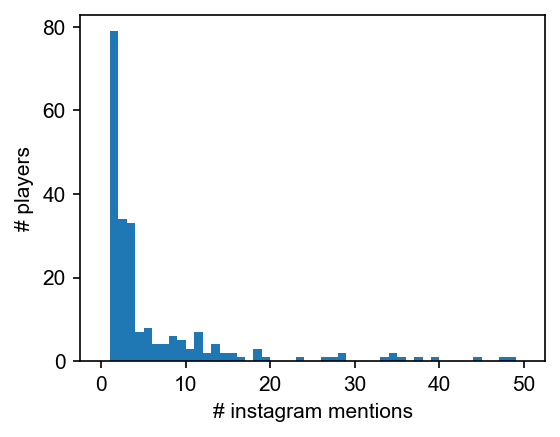

In [305]:
# Plot histogram of insta_mentions
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=150)
plt.hist(players_with_stats_df['insta_mentions'], bins=50, range=(0, 50))
plt.xlabel('# instagram mentions')
plt.ylabel('# players')
plt.show()

In [324]:
# Add other players with 0 mentions, if they have G > 0 and MP > 0.0
players_with_nominal_minutes_df = all_stats_df[(all_stats_df['G'] > 0) & (all_stats_df['MP'] > 0.0)][stats_to_keep].copy()
players_with_nominal_minutes_df = players_with_nominal_minutes_df[~players_with_nominal_minutes_df.index.isin(players_with_stats_df.index)]
players_with_nominal_minutes_df['insta_mentions'] = 0

# Add these players to the players_with_stats_df
players_with_stats_df = pd.concat([players_with_stats_df, players_with_nominal_minutes_df]).sort_index()
print("Players with nonzero Instagram mentions or nominal playing time:", len(players_with_stats_df))
display(players_with_stats_df.head(10))

Players with nonzero Instagram mentions or nominal playing time: 509


,insta_mentions,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV
player,,,,,,,,,,,,
A.J. Green,0,MIL,19.0,7.7,3.2,0.8,0.7,0.0,0.0,0.438,0.625,0.0
A.J. Lawson,0,DAL,11.0,8.3,3.5,0.7,0.4,0.4,0.1,0.469,0.531,0.5
AJ Griffin,0,ATL,12.0,9.2,2.5,1.0,0.3,0.1,0.0,0.294,0.412,0.3
Aaron Gordon,9,DEN,26.0,32.0,13.5,6.9,3.5,1.0,0.6,0.522,0.544,1.4
Aaron Holiday,1,HOU,24.0,18.1,7.0,1.9,1.7,0.5,0.1,0.453,0.566,0.6
Aaron Nesmith,2,IND,25.0,24.7,11.9,3.1,1.0,1.0,0.8,0.540,0.668,0.7
Aaron Wiggins,0,OKC,24.0,12.4,5.2,2.2,0.7,0.5,0.0,0.595,0.671,0.5
Admiral Schofield,0,ORL,8.0,3.5,0.9,0.6,0.3,0.0,0.0,0.300,0.350,0.5
Al Horford,3,BOS,23.0,26.7,7.7,7.1,2.8,0.4,1.0,0.472,0.585,1.0


In [325]:
# Save this processed dataframe
players_with_stats_df.to_csv('./data/202324_instagram_counts_and_stats.csv', index=True)

In [336]:
# # Look for specific phrases to test pipeline
# phrase = '@austinreaves12'
# display(df[df['caption'].str.contains(phrase)])

# Print all rows where the player is in player_lists_gpt-4-1106-preview
player = 'Austin Reaves'
display(df[df[col_name].apply(lambda x: player in x)])

,date,caption,likes,comments,comments:likes,player_lists_gpt-4-1106-preview
505,2023-11-02 04:12:17,AUSTIN REAVES. BREAKER OF ANKLES.,1379013,7376,0.005349,[Austin Reaves]
509,2023-11-02 05:03:08,@austinreaves12 plus the foul in OT!,105830,449,0.004243,[Austin Reaves]
704,2023-11-07 01:43:26,👀 @austinreaves12 with the PUTBACK DUNK on @nb...,154882,329,0.002124,[Austin Reaves]
852,2023-11-10 15:45:00,@austinreaves12 makes his picks for the NBA In...,72244,325,0.004499,[Austin Reaves]
983,2023-11-13 04:54:54,@austinreaves12 with some english on his dime ...,135945,236,0.001736,"[Austin Reaves, Anthony Davis]"
1190,2023-11-18 03:37:53,@austinreaves12 breaks down the defense in Por...,215051,457,0.002125,[Austin Reaves]
1286,2023-11-20 05:07:09,LeBron finds Reaves for the clutch triple!,190470,518,0.002720,"[LeBron James, Austin Reaves]"
1291,2023-11-20 06:36:25,@austinreaves12 with the point 👉🏻 @bronny foll...,52986,105,0.001982,[Austin Reaves]
1292,2023-11-20 06:46:14,🗣️ @austinreaves12 on @kingjames 👑,173743,722,0.004156,"[Austin Reaves, LeBron James]"
1431,2023-11-23 04:28:59,@austinreaves12 and @kingjames connection 💯,96440,155,0.001607,"[Austin Reaves, LeBron James]"
